**Problem**: Given a phishing url, classify the domain as compromised (owned) or malicious (hacked).

**Objective**: Given labeled data, analyze the best model and features.

In [4]:
import sklearn
print(sklearn.__version__)

0.19.1


# Setup

In [68]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

#from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# orange
from Orange.classification.rules import CN2Learner
from Orange.evaluation import compute_CD, graph_ranks

# scipy
import scipy
from scipy.stats import friedmanchisquare
from scipy.stats import rankdata

from pprint import pprint

import pickle

import numpy as np
from numpy import nan

import random

# Data

In [89]:
# balanced train and test sets
def balance_data(X, y):
    X_bal = []
    y_bal = []
    X_rest = []
    y_rest = []
    min1 = len([tar for tar in y if tar==1])
    min2 = len([tar for tar in y if tar==-1])
    mini = min1
    if min2 < min1:
        mini = min2

    cnt_1 = 0
    cnt_0 = 0
    print(mini)
    for i, tar in enumerate(y):
        if tar == 1 and cnt_1<mini:
            cnt_1+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        elif tar == -1 and cnt_0<mini:
            cnt_0+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        else:
            X_rest.append(X[i])
            y_rest.append(y[i])

    print("# X_bal:", len(X_bal))
    print("# y_bal:", len(y_bal))
    print("% compromised: ", len([tar for tar in y_bal if tar==1])/len(y_bal))
    print("% malicious: ", len([tar for tar in y_bal if tar==-1])/len(y_bal))
    
    print("# X_rest:", len(X_rest))
    print("# y_rest:", len(y_rest))
    print("% compromised: ", len([tar for tar in y_rest if tar==1])/len(y_rest))
    print("% malicious: ", len([tar for tar in y_rest if tar==-1])/len(y_rest))
    
    return [X_bal, y_bal, X_rest, y_rest]

### Train/Test

In [90]:
with open("data/data_cluster_5952", "r", encoding='utf-8') as f:
    data_train = eval(f.read())
    
random.Random(4).shuffle(data_train)

Xtrain = np.array([d['feat'] for d in data_train])
ytrain = np.array([d['target'] for d in data_train])
feat_labels = data_train[0]['feat_labels']
print(Xtrain.shape)
print(ytrain.shape)
print(feat_labels)
pprint(data_train[:5])
pprint(Xtrain[:5])
pprint(ytrain[:5])
print("# compromised: ", len([tar for tar in ytrain if tar==1]))
print("# malicious: ", len([tar for tar in ytrain if tar==-1]))
print("% compromised: ", len([tar for tar in ytrain if tar==1])/len(ytrain))
print("% malicious: ", len([tar for tar in ytrain if tar==-1])/len(ytrain))

(5952, 19)
(5952,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
[{'dataset': 'unlabeled-apwg',
  'feat': [1,
           9,
           0,
           18.0,
           0,
           0,
           0,
           1,
           0,
           1,
           nan,
           0.4166666666666667,
           0,
           0,
           9,
           67,
           0.1111111111111111,
           0,
           1],
  'feat_labels': ['archived',
                  'years_active',
                  'years_inactive',
                  'num_captures',
                  'freenom_tld',
                  'prev_mal_tld',
                  'wildcard_subdomain',
                  'reachable',
                  'redirected',
                  'blocked',
  

In [91]:
# balance
Xtrain, ytrain, Xtest, ytest = balance_data(Xtrain, ytrain)

2045
# X_bal: 4090
# y_bal: 4090
% compromised:  0.5
% malicious:  0.5
# X_rest: 1862
# y_rest: 1862
% compromised:  1.0
% malicious:  0.0


### Predict

In [86]:
with open("/home/sophie/SSRG/domainclassification/results/dataset/domain_target_55383", "r", encoding='utf-8') as f:
    data_predict = eval(f.read())
    
datasets = set([d['dataset'] for d in data_predict])
pprint(datasets)

{'comp-deltaphish',
 'comp-phishlabs',
 'mal-apwg',
 'mal-future-apwg',
 'mal-phishlabs',
 'unlabeled-apwg'}


#### Cluster training

In [88]:
#data used for cluster training
dataset_val = {"comp-phishlabs", "mal-apwg"}
Xval = np.array([d['feat'] for d in data_predict if d['dataset'] in dataset_val])
yval = np.array([d['target'] for d in data_predict if d['dataset'] in dataset_val])
feat_labels = data_predict[0]['feat_labels']
print(Xval.shape)
print(yval.shape)
print(feat_labels)
pprint(Xval[:5])
pprint(yval[:5])
print("# compromised: ", len([tar for tar in yval if tar==1]))
print("# malicious: ", len([tar for tar in yval if tar==-1]))
print("% compromised: ", len([tar for tar in yval if tar==1])/len(yval))
print("% malicious: ", len([tar for tar in yval if tar==-1])/len(yval))

(1164, 19)
(1164,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[0.00000000e+00,            nan,            nan,            nan,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00,            nan, 2.00000000e-01,
        1.00000000e+00, 0.00000000e+00, 6.00000000e+00, 0.00000000e+00,
        1.66666667e-01, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00,            nan,            nan,            nan,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00,            nan, 2.00000000e-01,
        1.00000000e+00, 0.00000000e+00, 6.00000000e+00, 0.00000000e+00,
        1.66666667e-01, 0.00000000e+00, 

#### Comp

In [10]:
#deltaphish
Xpredict = np.array([d['feat'] for d in data_predict if d['dataset'] == "comp-deltaphish"])
ypredict = np.array([d['target'] for d in data_predict if d['dataset'] == "comp-deltaphish"])
feat_labels = data_predict[0]['feat_labels']
print(Xpredict.shape)
print(ypredict.shape)
print(feat_labels)
pprint(Xpredict[:5])
pprint(ypredict[:5])
print("# compromised: ", len([tar for tar in ypredict if tar==1]))
print("# malicious: ", len([tar for tar in ypredict if tar==-1]))
print("% compromised: ", len([tar for tar in ypredict if tar==1])/len(ypredict))
print("% malicious: ", len([tar for tar in ypredict if tar==-1])/len(ypredict))

(689, 19)
(689,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[1.00000000e+00, 6.00000000e+00, 0.00000000e+00, 7.40000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00,            nan, 3.33333333e-01,
        1.00000000e+00, 0.00000000e+00, 5.00000000e+00, 6.70000000e+01,
        2.00000000e-01, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 8.00000000e+00, 1.00000000e+00, 9.50000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00,            nan, 6.66666667e-01,
        1.00000000e+00, 0.00000000e+00, 9.00000000e+00, 8.00000000e+01,
        1.11111111e-01, 1.00000000e+00, 1.

#### Mal

In [21]:
# phishlabs
Xpredict = np.array([d['feat'] for d in data_predict if d['dataset'] == "mal-phishlabs"])
ypredict = np.array([d['target'] for d in data_predict if d['dataset'] == "mal-phishlabs"])
feat_labels = data_predict[0]['feat_labels']
print(Xpredict.shape)
print(ypredict.shape)
print(feat_labels)
pprint(Xpredict[:5])
pprint(ypredict[:5])
print("# compromised: ", len([tar for tar in ypredict if tar==1]))
print("# malicious: ", len([tar for tar in ypredict if tar==-1]))
print("% compromised: ", len([tar for tar in ypredict if tar==1])/len(ypredict))
print("% malicious: ", len([tar for tar in ypredict if tar==-1])/len(ypredict))

(2804, 19)
(2804,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[0.00000000e+00,            nan,            nan,            nan,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   nan,            nan,            nan, 1.00000000e-01,
        1.00000000e+00, 0.00000000e+00, 7.00000000e+00, 0.00000000e+00,
        1.42857143e-01, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00,            nan,            nan,            nan,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   nan,            nan,            nan, 6.25000000e-02,
        1.00000000e+00, 0.00000000e+00, 1.30000000e+01, 1.00000000e+01,
        7.69230769e-02, 5.00000000e+00, 

In [25]:
# next apwg mal
Xpredict = np.array([d['feat'] for d in data_predict if d['dataset'] == "mal-future-apwg"])
ypredict = np.array([d['target'] for d in data_predict if d['dataset'] == "mal-future-apwg"])
feat_labels = data_predict[0]['feat_labels']
print(Xpredict.shape)
print(ypredict.shape)
print(feat_labels)
pprint(Xpredict[:5])
pprint(ypredict[:5])
print("# compromised: ", len([tar for tar in ypredict if tar==1]))
print("# malicious: ", len([tar for tar in ypredict if tar==-1]))
print("% compromised: ", len([tar for tar in ypredict if tar==1])/len(ypredict))
print("% malicious: ", len([tar for tar in ypredict if tar==-1])/len(ypredict))

(314, 19)
(314,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[  0.        ,          nan,          nan,          nan,
          0.        ,   1.        ,   1.        ,   0.        ,
                 nan,          nan,          nan,   0.35714286,
          0.        ,   0.        ,  10.        ,  80.        ,
          0.1       ,   0.        ,   1.        ],
       [  1.        ,   1.        ,   1.        ,  58.        ,
          0.        ,   0.        ,   0.        ,   1.        ,
          1.        ,   0.        ,          nan,   0.5       ,
          0.        ,   0.        ,   6.        ,  67.        ,
          0.16666667,   0.        ,   1.        ],
       [  0.        ,          nan,          nan,          na

# Normalize and imputer

In [92]:
imp = Imputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
Xtrain = imp.transform(Xtrain)
Xtest = imp.transform(Xtest)

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)
print(Xtrain[2])
print(Xtest[2])

[-9.57130780e-01 -2.94212290e-14 -4.53960112e-14 -4.82649436e-15
 -2.70930756e-02 -1.00097847e+00 -3.34690007e-01  6.31102684e-01
 -3.63865393e-01  2.09054962e+00  7.79082913e-14 -8.15833928e-01
 -2.05032233e-01 -2.19500388e-01  1.06720098e-01 -1.23356697e-01
 -4.01085238e-01  1.79553492e+00  2.64907042e-02]
[ 1.04530045e+00 -1.97585348e+00  6.88527646e-01 -1.67463169e-01
 -2.70930756e-02 -1.00097847e+00 -3.34690007e-01  6.31102684e-01
 -3.63865393e-01  2.09054962e+00  7.79082913e-14 -1.01955218e-01
 -2.05032233e-01 -2.19500388e-01  3.62509299e+00  1.08052036e-01
 -9.39025178e-01 -3.55215650e-01 -6.71540497e-02]


In [93]:
Xval = imp.transform(Xval)
Xval = scaler.transform(Xval)
print(Xval[:2])

[[-9.57130780e-01 -2.94212290e-14 -4.53960112e-14 -4.82649436e-15
  -2.70930756e-02 -1.00097847e+00 -3.34690007e-01  6.31102684e-01
  -3.63865393e-01 -6.68862670e-01  7.79082913e-14 -1.30761704e+00
   4.87728191e+00 -2.19500388e-01 -7.21132346e-01 -3.99945298e+00
   1.68498229e-01 -3.55215650e-01 -6.71540497e-02]
 [-9.57130780e-01 -2.94212290e-14 -4.53960112e-14 -4.82649436e-15
  -2.70930756e-02 -1.00097847e+00 -3.34690007e-01  6.31102684e-01
  -3.63865393e-01 -6.68862670e-01  7.79082913e-14 -1.30761704e+00
   4.87728191e+00 -2.19500388e-01 -7.21132346e-01 -3.99945298e+00
   1.68498229e-01 -3.55215650e-01 -6.71540497e-02]]


# Visualize data with t-SNE

Takes a high dimensional dataset and reduces to a low dimensional graph that retains a lot of the original information.

What t-SNE does is find a way to project data into a low dimensional space so that the clustering in the high dimensional space is preserved.

O(n^2) time and memory. 

In [22]:
def plottsne(data, ax, title=None):
    X_embedded = data[0]
    y = data[1]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1],
                c=y, marker='o', alpha=.3)
    #plt.colorbar(sc)
    if title:
        ax.set_title(title)
    return sc

In [23]:
def plotsidebyside(tr, te, title1=None, title2=None):
    # display images
    fig, ax = plt.subplots(1,2)
    #fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(15, 7)
    
    if tr:
        sc_tr = plottsne(tr, ax[0], title1)
    if te:
        sc_te = plottsne(te, ax[1], title2)
    
    #plt.figure(figsize=(15, 15))
    print("blue malicious (owned), yellow compromised (hacked)")

In [24]:
Xtrain_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(Xtrain)

blue malicious (owned), yellow compromised (hacked)


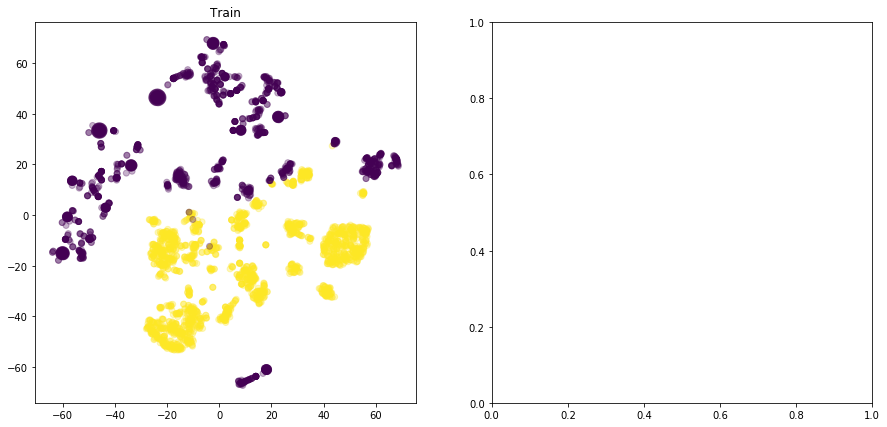

In [25]:
plotsidebyside([Xtrain_embedded, ytrain], None, title1="Train", title2="Test")

# ROC
Compare the performance of each model.

In [102]:
names = [
         "KNeighbors", 
         "RBF-SVM", 
         "Decision-Tree", 
         #"CN2Learner",
         "Random-Forest",
         "Dummy",
        ]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf", probability=True),
    DecisionTreeClassifier(),
    #CN2Learner(),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=42),
    DummyClassifier(),
]

In [103]:
def plot_roc_curve(fpr, tpr, ax, axins, name, label=None):
    #plt.xlim(0, 0.2)
    #plt.ylim(0.6, 1)
    #ax.plot(fpr, tpr, 'r', linewidth=2, label=label)
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.grid()
    if axins and name == 'Random Forest':
        axins.plot(fpr, tpr, 'r', linewidth=2)
        axins.grid()
        axins.set_xticks(ticks=[0,5,10,15,20])
        axins.set_yticks(ticks=[60,70,80,90,100])

In [104]:
def getRoc(data, title=None):
    X, y = data
    y = y
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    axins = inset_axes(ax, width=2, height=1.5, loc=10)
    #axins = inset_axes(ax)

    #plt.figure(figsize=(8, 6))
    #ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Postive Rate (%)')
    ax.set_ylabel('True Positive Rate (%)')
    ax.axis([0, 100, 0, 100])
    ax.set_xticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])
    ax.set_yticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])
    
    #axins.set_xlim([0, 0.5])
    #axins.set_ylim([0.6, 1])
    axins.axis([0, 20, 60, 100])
    #plt.axis([0, 1, 0, 1])
    #plt.xlabel('False Positive Rate', fontsize=16)
    #plt.ylabel('True Positive Rate', fontsize=16)

    for name, clf in zip(names, classifiers):
        y_scores = cross_val_predict(clf, X, y, cv=10, method="predict_proba")
        fpr, tpr, thresholds = roc_curve(y, y_scores[:, 1])
        fpr, tpr = fpr*100, tpr*100
        roc_auc = auc(fpr, tpr)/(100*100)
        plot_roc_curve(fpr, tpr, ax, axins, name, label='%s (AUC = %0.3f)' % (name, roc_auc))
        clf.fit(X,y)
        
        # second validation
        predicted_proba = clf.predict_proba(Xval)
        fpr, tpr, thresholds = roc_curve(yval, predicted_proba[:, 1])
        fpr, tpr = fpr*100, tpr*100
        roc_auc = auc(fpr, tpr)/(100*100)
        print(name)
        print(roc_auc)
        

    ax.legend()
    #plt.show()

KNeighbors
0.8288641270704051
RBF-SVM
0.8521613745828992
Decision-Tree
0.8338587670426234
Random-Forest
0.9245157101659345
Dummy
0.48251574036327394


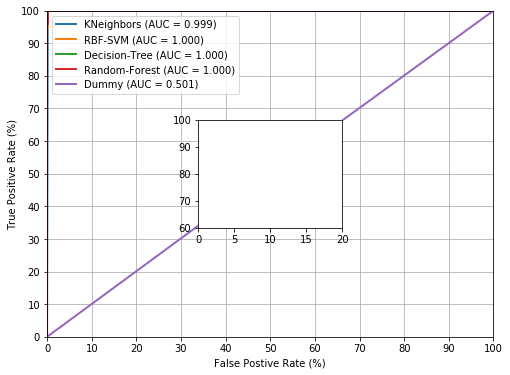

In [105]:
getRoc([Xtrain, ytrain])

In [17]:
clf = classifiers[1]
name = names[1]
model = clf.fit(Xtrain, ytrain)

#threshold = 0.67
threshold = 0.5
#threshold = 0.33

predicted = model.predict(Xtest)

tn, fp, fn, tp = confusion_matrix(ytest, predicted, labels=[-1,1]).ravel()
print(np.array([[tp, fp],[fn, tn]]))
print("acc: ", accuracy_score(ytest, predicted))
print("tpr: ", tp/(tp+fn))
print("fpr: ", fp/(tn+fp))
#print("f1: ", f1_score(ytrain, predicted, average='micro'))
print("f1: ", f1_score(ytest, predicted))

[[1861    0]
 [   1    0]]
acc:  0.9994629430719656
tpr:  0.9994629430719656
fpr:  nan
f1:  0.9997313994090786


/home/sophie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


# Features

In [32]:
def getAUC(X, y, feat=""):
    y_scores = cross_val_predict(clf, X, y, cv=5, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    #print("%s: AUC %s" % (feat, roc_auc))
    #print()
    return roc_auc, feat

#### Individual

In [33]:
auc_feat_list = []
print(feat_labels)
paper_feat_labels = feat_labels
#paper_feat_labels = ["Archived", "Years active", "Years inactive", "Number of captures", "Archive redirected", "Freenom TLD", "Wildcard subdomain", "Reachable", "Blocked", "Alexa rank", "Ratio of longest word", "Contain digits", "Contain hyphen", "Name length", "Match brand name"]
for i, feat in enumerate(paper_feat_labels):
    if 'excluded' in feat:
        continue
    X = Xtrain[:,i].reshape(-1, 1)
    auc_feat_list.append(getAUC(X, ytrain, feat))

ftld = auc_feat_list[5]
auc_feat_list[5] = auc_feat_list[7]

wcsd = auc_feat_list[6]
auc_feat_list[6] = auc_feat_list[8]

auc_feat_list[7] = wcsd
auc_feat_list[8] = auc_feat_list[9]
auc_feat_list[9] = ftld
pprint(auc_feat_list)

['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
[(0.8954117921341934, 'archived'),
 (0.929989060323647, 'years_active'),
 (0.9103898231120091, 'years_inactive'),
 (0.9311929029596906, 'num_captures'),
 (0.5009290953545232, 'freenom_tld'),
 (0.6737408312958436, 'reachable'),
 (0.7225191145437917, 'redirected'),
 (0.5516860850903569, 'wildcard_subdomain'),
 (0.7762653260083333, 'blocked'),
 (0.9995599022004891, 'prev_mal_tld'),
 (0.6095843520782397, 'alexa_rank'),
 (0.7365008578380091, 'ratio_longest_word'),
 (0.4933424596935695, 'contain_digit'),
 (0.48565120964126235, 'contain_dash'),
 (0.8410435136088377, 'name_len'),
 (0.6767391395316862, 'brandname_partialratio'),
 (0.843001058099844, 'prev_mal_domain_ed'),
 (0.6748224843227862

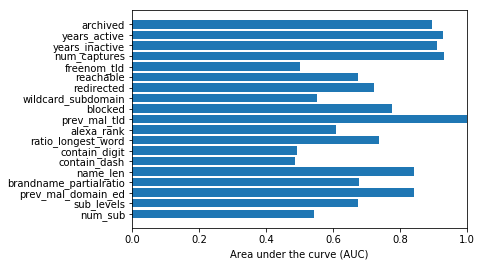

In [34]:
aucs = [x[0] for x in auc_feat_list]
feats = [x[1] for x in auc_feat_list]

fig, ax = plt.subplots()
plt.figure(figsize=(15,10))

# Example data
y_pos = np.arange(len(feats))

ax.barh(y_pos, aucs, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Area under the curve (AUC)')
ax.set_xlim([0,1])
#ax.set_title('How fast do you want to go today?')

plt.show()

# Predict

In [106]:
datasets = set([d['dataset'] for d in data_predict])
print(datasets)
dataset_predict = {'comp-deltaphish','mal-future-apwg','mal-phishlabs'}
compare_datasets = []
compare_names = []
for dataset in dataset_predict:
    clf_datasets = []
    clf_names = []
    for name, clf in zip(names, classifiers):
        clf.fit(Xtrain, ytrain)
        
        # get X and y for specific datasets
        Xpredict = np.array([d['feat'] for d in data_predict if d['dataset'] in dataset])
        ypredict = np.array([d['target'] for d in data_predict if d['dataset'] in dataset])
        
        # transform (handle nan and normalize)
        Xpredict = imp.transform(Xpredict)
        Xpredict = scaler.transform(Xpredict)
        
        # predict
        Xpredict_pred = clf.predict(Xpredict)
        #tn, fp, fn, tp = confusion_matrix(ypredict, Xpredict_pred, labels=[-1,1]).ravel()
        
        # evaluation criteria
        acc = accuracy_score(ypredict, Xpredict_pred)
        err = 1-acc
        #avg_acc = (tp+tn)/2
        
        # add avg_acc and corresponding name label
        clf_datasets.append(err)
        clf_name = '-'.join([name, dataset])
        print(clf_name)
        clf_names.append(clf_name)
    
    # add dataset results for specific clf
    compare_datasets.append(clf_datasets)
    compare_names.append(clf_names)

{'mal-future-apwg', 'unlabeled-apwg', 'mal-apwg', 'mal-phishlabs', 'comp-phishlabs', 'comp-deltaphish'}
KNeighbors-comp-deltaphish
RBF-SVM-comp-deltaphish
Decision-Tree-comp-deltaphish
Random-Forest-comp-deltaphish
Dummy-comp-deltaphish
KNeighbors-mal-future-apwg
RBF-SVM-mal-future-apwg
Decision-Tree-mal-future-apwg
Random-Forest-mal-future-apwg
Dummy-mal-future-apwg
KNeighbors-mal-phishlabs
RBF-SVM-mal-phishlabs
Decision-Tree-mal-phishlabs
Random-Forest-mal-phishlabs
Dummy-mal-phishlabs


In [107]:
print(compare_datasets)

[[0.23512336719883886, 0.010159651669085612, 0.0, 0.09288824383164007, 0.5021770682148041], [0.2261146496815286, 0.4426751592356688, 0.5031847133757962, 0.08917197452229297, 0.5382165605095541], [0.24607703281027105, 0.6569186875891584, 0.9935805991440799, 0.13302425106990012, 0.5099857346647646]]


# Friedman test and Nemenyi CD

In [108]:
# compare samples
stat, p = friedmanchisquare(compare_datasets[0], compare_datasets[1], compare_datasets[2])
#stat, p = friedmanchisquare(compare_datasets[0], compare_datasets[2], compare_datasets[4])

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=5.200, p=0.074
Same distributions (fail to reject H0)


In [28]:
from numpy.random import seed
from numpy.random import randn
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52
# compare samples
stat, p = friedmanchisquare(data1, data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=9.360, p=0.009
Different distributions (reject H0)


In [109]:
ranks = []
for comp in compare_datasets:
    rank = rankdata(comp)
    ranks.append(rank)
print(ranks)
avranks = np.mean(ranks, axis=0)
print(avranks)

[array([4., 2., 1., 3., 5.]), array([2., 3., 4., 1., 5.]), array([2., 4., 5., 1., 3.])]
[2.66666667 3.         3.33333333 1.66666667 4.33333333]


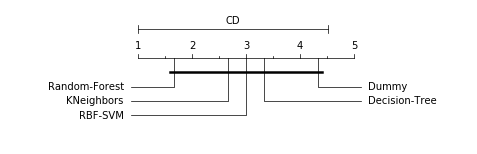

In [110]:
#names = ["first", "third", "second", "fourth" ]
#avranks =  [1.9, 3.2, 2.8, 3.3 ]
num_datasets = len(dataset_predict)
cd = compute_CD(avranks, num_datasets)
graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show()

# Model persistence

In [17]:
from joblib import dump, load
modelname = 'apwg'
filename = './model/'+modelname+'_scaler.joblib'
dump(scaler, filename)

['finalized_scaler.joblib']

In [21]:
filename = './model/'+modelname+'_imputer.joblib'
dump(imp, filename)

['finalized_imputer.joblib']

In [14]:
clf = classifiers[3]
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
#from joblib import dump, load
filename = './model/'+modelname+'_model.joblib'
dump(clf, filename)
#pickle.dump(clf, 'mlp.joblib') 

['finalized_model.joblib']